# Testing Hadamard MGP with GPytorch

In [222]:
import numpy as np
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [223]:
from collections import defaultdict
nested_dict = lambda: defaultdict(nested_dict)

def generate_dataset(n_samples=5, n_tasks=3):
    """
    Generating Variable Length, Irregularly observed Time Series (with sine and cosine)
    Returns:
    -data dict:
        'x':
            'task_0': list of tensors
            'task_1': ..
             .. (n_tasks-1)
        'y': 
            'task_0': list of tensors
            'task_1': ..
             .. (n_tasks-1)
    list elements represent samples / instances
    """
    #determine labels (balanced)
    n_cases = int(np.floor(n_samples/2))
    n_controls = int(n_samples - n_cases)
    labels = torch.cat([torch.ones(n_cases), torch.zeros(n_controls)])
    #add signals correlated with label:
    signal = 5 #affects the frequency of the sine/cosines
    
    #first draw number of observations per sample (uniform between 20 and 50)
    lengths = torch.randint(50, 150, (n_tasks,n_samples))
    data = nested_dict()
    for i, length in enumerate(lengths): #loop over tasks
        x_list = []
        y_list = []
        for j, l in enumerate(length): #loop over samples
            x = torch.rand(l)
            if i % 2 == 0: #even tasks with sin, uneven with cos
                y = torch.sin(torch.randn(1) + x * ((5 + (signal*labels[j])*torch.randn(1))* math.pi)) + torch.randn(x.size()) * 0.1
            else:
                y = torch.cos(torch.randn(1) + x * ((5+ (signal*labels[j])*torch.randn(1))* math.pi)) + torch.randn(x.size()) * 0.1
            x_list.append(x)
            y_list.append(y)
        data['x']['task_' + str(i)] = x_list
        data['y']['task_' + str(i)] = y_list
    return data, labels    

In [65]:
data['x']['task_0'][1]

tensor([0.8174, 0.6657, 0.4645, 0.9982, 0.0548, 0.9218, 0.2124, 0.9287, 0.5332,
        0.0736, 0.9239, 0.1297, 0.1591, 0.1379, 0.5650, 0.9262, 0.4707, 0.3113,
        0.6686, 0.9611, 0.6625, 0.9745, 0.4989, 0.0886, 0.8711, 0.1661, 0.9802,
        0.7253, 0.3988, 0.9764, 0.0031, 0.5397, 0.6229, 0.3085, 0.3637, 0.0044,
        0.8391, 0.8993, 0.4104, 0.4698, 0.8983, 0.4401, 0.2363, 0.4435, 0.2248,
        0.6629, 0.3228, 0.2829, 0.3542, 0.0209, 0.9606, 0.3420, 0.5383, 0.8460,
        0.4802, 0.8295, 0.2856, 0.6558, 0.6114, 0.8268, 0.8741, 0.4631, 0.7395,
        0.9389, 0.9510, 0.6276, 0.2937, 0.6507, 0.6520, 0.1873, 0.0276, 0.8662,
        0.6777, 0.7822, 0.8170, 0.4012, 0.2637, 0.6590, 0.5792, 0.1686, 0.8780,
        0.5862, 0.4328, 0.1543, 0.7634, 0.5088, 0.1337, 0.7157, 0.6443, 0.6349,
        0.5156, 0.1997, 0.2053, 0.0436, 0.8490, 0.1793, 0.6690, 0.3558, 0.4818,
        0.3054, 0.0819, 0.7329, 0.7328, 0.8675, 0.3759, 0.3625, 0.9626, 0.2012,
        0.9311, 0.1507, 0.3232, 0.9199, 

In [38]:
from torch.utils.data import Dataset

In [83]:
class SyntheticData(Dataset):
    def __init__(self, n_samples=500, n_tasks=3):
        """
        Generate synthetic data when initializing
        """
        self.data, self.labels = generate_dataset(n_samples, n_tasks)
        
        #prepare data for hadamard GP setup (decompose into inputs (times), task indices and observed values)
        self.inputs, self.values, self.indices = prepare_train_data(self.data)

    def __len__(self):
        return self.values.shape[0]

    def __getitem__(self, idx):
        return self.values[idx]
    

In [84]:
syn_dat = SyntheticData()

torch.Size([500, 435])

In [224]:
from collections import defaultdict
nested_dict = lambda: defaultdict(nested_dict)

In [225]:
def generate_test_points(n_samples=5, n_tasks=3, n_query=51):
    inputs = torch.linspace(0, 1, n_query)
    
    def get_indices(data,fill=0):
        return torch.full_like(data, dtype=torch.long, fill_value=fill)
    indices = torch.stack(
                   [ torch.cat(
                        [get_indices(inputs, i) for i in np.arange(n_tasks)]
                    ) for j in np.arange(n_samples)
                   ]
    ) 
    
    inputs = inputs.repeat(n_samples,n_tasks)

    #add extra dimension for GPytorch:
    inputs = inputs.unsqueeze(-1)
    indices = indices.unsqueeze(-1)
    return inputs, indices


In [226]:
n_samples=10
n_tasks=3
data,labels = generate_dataset(n_samples=n_samples, n_tasks=n_tasks)

tensor([1., 1., 1., 1., 1., 0., 0., 0., 0., 0.])

In [227]:
n_query=51
test_inputs, test_indices = generate_test_points(n_samples=n_samples, n_tasks=n_tasks, n_query=n_query)

In [228]:
def plot_data(data):
    n_samples = len(data['x']['task_0'])
    n_tasks = len(list(data['x'].keys()))
    fig, ax = plt.subplots(n_samples, figsize=(10,10))
    for i in np.arange(n_samples):
        for j in np.arange(n_tasks):  
            x = data['x']['task_'+str(j)][i]
            y = data['y']['task_'+str(j)][i]
            ax[i].plot(x,y, 'o')

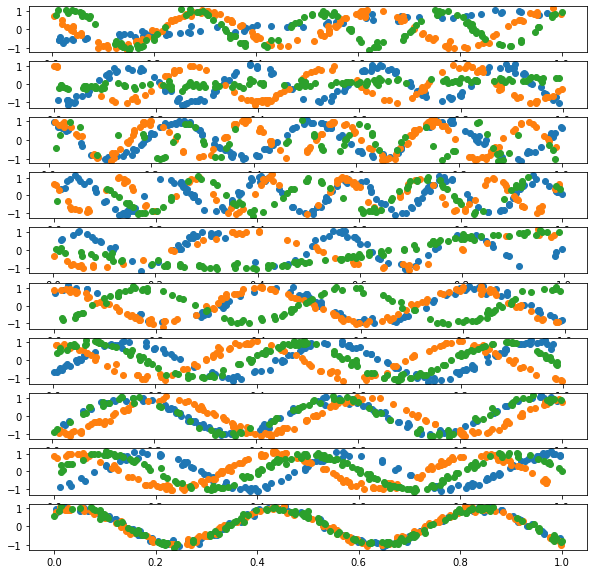

In [229]:
plot_data(data) 

In [230]:
def pad_data(data_list, fill=0):
    """
    Pad tensors with fill-value such that list of variable shaped tensors can be stacked
    """
    n_samples = len(data_list)
    #first determine longest time series:
    lengths = [x.shape[0] for x in data_list]
    max_len = max(lengths)
    
    output = fill*torch.ones((n_samples, max_len))
    for i in np.arange(n_samples):
        output[i,:lengths[i]] = data_list[i]
    return output
        

In [231]:
def merge_tasks(data):
    """
    For GPyTorch MGP, the tasks need to be merged into one tensor, and a index tensor identifies the task at hand
    Inputs:
    - data: nested dictionary, from generate_dataset()
    Returns:
    - x: [n_samples, len_all_tasks]
    - y: [n_samples, len_all_tasks] 
    - task_indices: [n_samples, len_all_tasks] 
    
    """
    n_samples = len(data['x']['task_0'])
    n_tasks = len(list(data['x'].keys()))
    
    #first determine maximal length of all tasks
    inputs_samples = [] # as final output size is not known here, we append all data to list..
    values_samples = []
    indices_samples = [] 
   
    for i in np.arange(n_samples):
        indices_list = []
        inputs_list = []
        values_list = []
        for j in np.arange(n_tasks):
            x = data['x']['task_' + str(j)][i]
            y = data['y']['task_'+str(j)][i]
            task_index = torch.full_like(x, dtype=torch.long, fill_value=j)
            #Append data per task into one list, and then concatenate it
            inputs_list.append(x)
            values_list.append(y)
            indices_list.append(task_index)
        #Get tensor of current sample
        inputs = torch.cat(inputs_list)
        values = torch.cat(values_list)
        indices = torch.cat(indices_list)

        #Append all tensors to list over samples
        inputs_samples.append(inputs)
        values_samples.append(values)
        indices_samples.append(indices)
    
    return  pad_data(inputs_samples), pad_data(values_samples), pad_data(indices_samples,fill=n_tasks).to(dtype=torch.long)
    #we pad the task indices with 99 as an exotic number, to not mix it up with real tasks
    

In [232]:
inputs, values, indices = merge_tasks(data)


In [233]:
# GPyTorch seems to require additional dim for inputs
inputs = inputs.unsqueeze(-1)
indices = indices.unsqueeze(-1)

In [234]:
def prepare_train_data(data):
    inputs, values, indices = merge_tasks(data)
    inputs = inputs.unsqueeze(-1)
    indices = indices.unsqueeze(-1)
    return inputs, values, indices

In [282]:
inputs, values, indices = prepare_train_data(data)

torch.Size([10, 298, 1])

## Debugging:

In [446]:
#stick to single sample:
inputs, values, indices = inputs[0], values[0], indices[0]

In [22]:
inputs.size(), values.size(), indices.size()

(torch.Size([5, 343, 1]), torch.Size([5, 343]), torch.Size([5, 343, 1]))

In [23]:
inputs.type(), values.type(), indices.type()

('torch.FloatTensor', 'torch.FloatTensor', 'torch.LongTensor')

In [412]:
#Debugging:
train_x1 = torch.rand(180)
train_x2 = torch.rand(180)
train_y1 = torch.sin(train_x1 * (2 * math.pi)) + torch.randn(train_x1.size()) * 0.2
train_y2 = torch.cos(train_x2 * (2 * math.pi)) + torch.randn(train_x2.size()) * 0.2
train_i_task1 = torch.full_like(train_x1, dtype=torch.long, fill_value=0)
train_i_task2 = torch.full_like(train_x2, dtype=torch.long, fill_value=1)

inputs = torch.cat([train_x1, train_x2])
indices = torch.cat([train_i_task1, train_i_task2])
values = torch.cat([train_y1, train_y2])

# MGP Model

In [283]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_tasks=2):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.RBFKernel()

        # We learn an IndexKernel for 2 tasks
        # (so we'll actually learn 2x2=4 tasks with correlations)
        self.task_covar_module = gpytorch.kernels.IndexKernel(num_tasks=num_tasks, rank=3)

    def forward(self,x,i):
        mean_x = self.mean_module(x)

        # Get input-input covariance
        covar_x = self.covar_module(x)
        # Get task-task covariance
        covar_i = self.task_covar_module(i)
        # Multiply the two together to get the covariance we want
        covar = covar_x.mul(covar_i)

        return gpytorch.distributions.MultivariateNormal(mean_x, covar)

likelihood = gpytorch.likelihoods.GaussianLikelihood()

### try out set_train_data() with synthetic data to ensure that new batch inputs + values are used for posterior distribution!

In [284]:
#start MGP layer for MGP-Sig adapter:
class MGP_Layer(MultitaskGPModel):
    def __init__(self,likelihood, num_tasks=2):
        super().__init__(None, None, likelihood, num_tasks) 
        #we don't intialize with train data for more flexibility
        likelihood.train()
        
    def forward(self, inputs, indices):
        return super(MGP_Layer, self).forward(inputs, indices)
    
    def condition_on_train_data(self, inputs, indices, values):
        self.set_train_data(inputs=(inputs, indices), targets=values, strict=False)

In [157]:
class MGPSig():
    def __init():
        pass
    def forward():
        raise NotImplementedError
        return "Very high accuracy"

In [285]:
# Here we have two iterms that we're passing in as train_inputs
#model = MultitaskGPModel((inputs, indices), values, likelihood, num_tasks=n_tasks+1)

#model = MultitaskGPModel(None, None, likelihood, num_tasks=n_tasks+1)
model = MGP_Layer(likelihood, num_tasks=n_tasks+1) 

MGP_Layer(
  (likelihood): GaussianLikelihood(
    (quadrature): GaussHermiteQuadrature1D()
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): RBFKernel(
    (raw_lengthscale_constraint): Positive()
  )
  (task_covar_module): IndexKernel(
    (raw_var_constraint): Positive()
  )
)

In [271]:
# Find optimal model hyperparameters
model.train() 
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(100):
    #model.update_data(inputs=(inputs, indices), targets=values)
    model.set_train_data(inputs=(inputs, indices), targets=values, strict=False)
    optimizer.zero_grad()
    output = model(inputs, indices)
    loss = -mll(output, values).mean()
    loss.backward()
    print('Iter %d/50 - Loss: %.3f' % (i + 1, loss.item()))
    optimizer.step()

RecursionError: maximum recursion depth exceeded while calling a Python object

In [286]:
# Train MGP Layer:
model.train() 
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(100):
    #model.update_data(inputs=(inputs, indices), targets=values)
    model.condition_on_train_data(inputs, indices, values)
    optimizer.zero_grad()
    output = model(inputs, indices)
    loss = -mll(output, values).mean()
    loss.backward()
    print('Iter %d/50 - Loss: %.3f' % (i + 1, loss.item()))
    optimizer.step()

Iter 1/50 - Loss: 1.044
Iter 2/50 - Loss: 1.026
Iter 3/50 - Loss: 1.010
Iter 4/50 - Loss: 0.996
Iter 5/50 - Loss: 0.983
Iter 6/50 - Loss: 0.973
Iter 7/50 - Loss: 0.965
Iter 8/50 - Loss: 0.959
Iter 9/50 - Loss: 0.956
Iter 10/50 - Loss: 0.955
Iter 11/50 - Loss: 0.955
Iter 12/50 - Loss: 0.957
Iter 13/50 - Loss: 0.958
Iter 14/50 - Loss: 0.959
Iter 15/50 - Loss: 0.959
Iter 16/50 - Loss: 0.957
Iter 17/50 - Loss: 0.954
Iter 18/50 - Loss: 0.949
Iter 19/50 - Loss: 0.943
Iter 20/50 - Loss: 0.934
Iter 21/50 - Loss: 0.922
Iter 22/50 - Loss: 0.904
Iter 23/50 - Loss: 0.881
Iter 24/50 - Loss: 0.852
Iter 25/50 - Loss: 0.819
Iter 26/50 - Loss: 0.782
Iter 27/50 - Loss: 0.739
Iter 28/50 - Loss: 0.693
Iter 29/50 - Loss: 0.644
Iter 30/50 - Loss: 0.596
Iter 31/50 - Loss: 0.541
Iter 32/50 - Loss: 0.490
Iter 33/50 - Loss: 0.431
Iter 34/50 - Loss: 0.382
Iter 35/50 - Loss: 0.336
Iter 36/50 - Loss: 0.294
Iter 37/50 - Loss: 0.263
Iter 38/50 - Loss: 0.226
Iter 39/50 - Loss: 0.180
Iter 40/50 - Loss: 0.149
Iter 41/5

MultitaskGPModel(
  (likelihood): GaussianLikelihood(
    (quadrature): GaussHermiteQuadrature1D()
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): RBFKernel(
    (raw_lengthscale_constraint): Positive()
    (distance_module): Distance()
  )
  (task_covar_module): IndexKernel(
    (raw_var_constraint): Positive()
  )
)

In [183]:
obj = likelihood(model(inputs,indices))

AttributeError: 'MultivariateNormal' object has no attribute 'std'

In [287]:
# Set into eval mode
model.eval()
likelihood.eval()

# Make predictions - one task at a time
# We control the task we cae about using the indices

# The gpytorch.settings.fast_pred_var flag activates LOVE (for fast variances)
# See https://arxiv.org/abs/1803.06058
with torch.no_grad(), gpytorch.settings.fast_pred_var():
#with torch.no_grad(), gpytorch.settings.fast_pred_var():
    #observed_pred_y1 = likelihood(model(test_x, test_i_task1))
    #dummy = torch.sum(likelihood(model(test_inputs, test_indices)).mean)
    #dummy.backward() 
    observed_pred_y = likelihood(model(test_inputs, test_indices))

In [172]:
# model.zero_grad()
model.covar_module.raw_lengthscale.grad

tensor([[-269.7131]])

(tensor([[-2.7246e+04, -5.1546e+04,  6.1281e+04,  ...,  1.8324e+04,
          -2.8152e+03,  2.4148e+03],
         [ 2.7463e+04,  1.0999e+04,  3.9659e+04,  ..., -6.8586e+03,
           2.4551e+04,  1.9623e+04],
         [ 3.7105e+05,  1.6998e+05,  1.0199e+04,  ...,  2.4419e+04,
          -1.0439e+04,  3.3963e+04],
         ...,
         [-3.3661e+00, -5.4537e-01, -7.1001e-01,  ..., -2.5047e+00,
           6.3184e-01,  1.9823e+00],
         [-7.9858e+04, -1.1307e+04,  6.0891e+04,  ...,  1.2760e+04,
           3.7473e+02, -1.4862e+04],
         [ 1.7888e+05,  3.6233e+04, -3.9535e+04,  ..., -6.0309e+04,
          -1.3425e+05, -2.7294e+04]], grad_fn=<SubBackward0>),
 tensor([[-2.7241e+04, -5.1544e+04,  6.1284e+04,  ...,  1.8326e+04,
          -2.8138e+03,  2.4172e+03],
         [ 2.7465e+04,  1.1001e+04,  3.9661e+04,  ..., -6.8564e+03,
           2.4553e+04,  1.9625e+04],
         [ 3.7105e+05,  1.6998e+05,  1.0201e+04,  ...,  2.4421e+04,
          -1.0437e+04,  3.3967e+04],
         ...,
 

In [240]:
def extract_train_data(data, indices, sample, task):
    """
    Utiliy function to extract data (values or inputs) of tensor for a single sample and task
    """
    return data.squeeze()[sample,:][indices.squeeze()[sample,:] == task]


def extract_test_data(data, n_query, sample, task):
    return data[sample,n_query*(task):n_query*(task+1)]

Text(0.5, 1.0, 'GPyTorch Hadamard MGP with global parameters (shared over samples)')

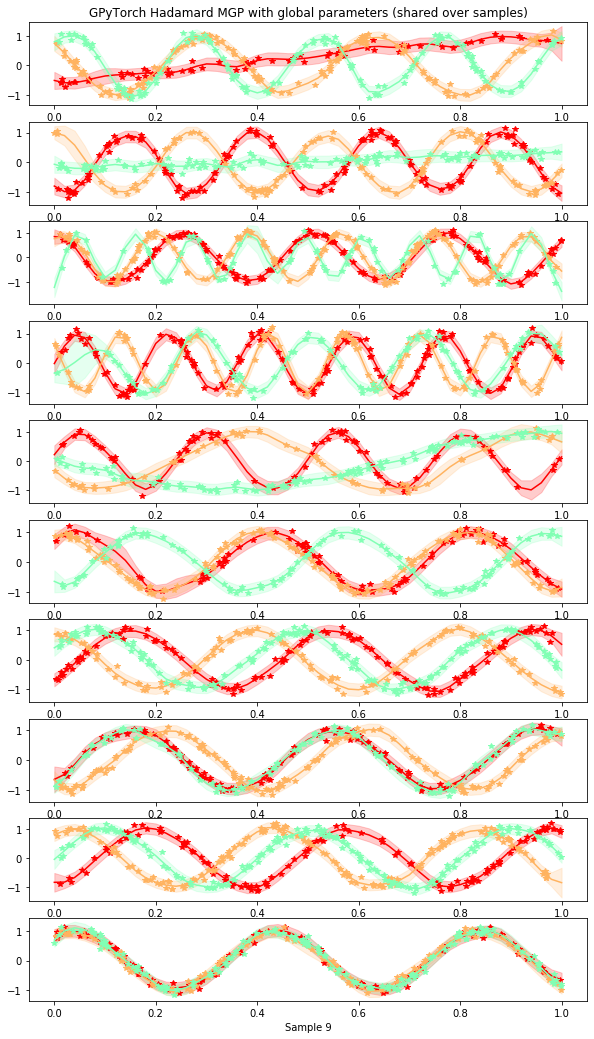

In [288]:
from matplotlib.pyplot import cm
colors=cm.rainbow(np.linspace(1,0,n_tasks+2))

# Initialize plots
f, ax = plt.subplots(n_samples, figsize=(10, 18))

# Unpack predictions:
mean = observed_pred_y.mean
lower, upper = observed_pred_y.confidence_region()

for i in np.arange(n_samples):
    for j in np.arange(n_tasks):
        # Plot training data as black stars
        #get train input data of current sample and task:
        train_x = extract_train_data(inputs, indices, i, j)
        train_y = extract_train_data(values, indices, i, j)
        #Plot train data (irregularly observed)
        ax[i].plot(train_x.detach().numpy(), train_y.detach().numpy(), '*', c=colors[j])
        
        test_x = extract_test_data(test_inputs.squeeze(), n_query, i, j)
        test_y_mean = extract_test_data(mean, n_query, i, j)
        
        ax[i].plot(test_x.detach().numpy(), test_y_mean.detach().numpy(), 'b', c=colors[j]) #, 'b'
        
        test_y_lower = extract_test_data(lower, n_query, i, j)
        test_y_upper = extract_test_data(upper, n_query, i, j)
        
        ax[i].fill_between(test_x.detach().numpy(), test_y_lower.detach().numpy(), test_y_upper.detach().numpy(), alpha=0.2, color=colors[j])
        
        ax[i].set_xlabel(f'Sample {i}')
ax[0].set_title('GPyTorch Hadamard MGP with global parameters (shared over samples)')

In [204]:
f.savefig('plots/hadamard_MGP.pdf')

FileNotFoundError: [Errno 2] No such file or directory: 'plots/hadamard_MGP.pdf'

In [242]:
for param_name, param in model.named_parameters():
    print(f'Name: {param_name} Value = {param.data}')

Name: likelihood.noise_covar.raw_noise Value = tensor([-5.5567])
Name: mean_module.constant Value = tensor([0.0436])
Name: covar_module.raw_lengthscale Value = tensor([[-4.5031]])
Name: task_covar_module.covar_factor Value = tensor([[-0.1763,  0.0035, -0.1297],
        [-0.0261,  0.1377, -0.0258],
        [-0.1691,  0.2356,  0.0567],
        [ 0.0633, -0.0598, -0.0617]])
Name: task_covar_module.raw_var Value = tensor([-1.2762, -0.9626, -1.6848, -5.6450])


<generator object Module.parameters at 0x129383250>

In [29]:
test_x = torch.linspace(0, 1, 51).repeat(4,1).unsqueeze(-1)

In [30]:
test_x.shape

torch.Size([4, 51, 1])

In [ ]:
# Initialize plots
f, ax = plt.subplots(n_samples, figsize=(20, 15))

n_tasks = train_y.shape[-1]
for i in np.arange(n_samples):
    for j in np.arange(n_tasks):
        # Plot training data as black stars
        ax[i,j].plot(train_x[i].detach().numpy(), train_y[i,:,j].detach().numpy(), 'k*')
        
        # Predictive mean as blue line
        ax[i,j].plot(test_x[i].numpy(), mean[i,:,j].numpy(), 'b')
        # Shade in confidence
        ax[i,j].fill_between(test_x[i].numpy().squeeze(), lower[i,:,j].numpy(), upper[i,:,j].numpy(), alpha=0.5)
        #ax[i,j].set_ylim([-3, 3])
        #ax[i,j].legend(['Observed Data', 'Mean', 'Confidence'])
        #ax[i,j].set_title('Observed Values (Likelihood)')


In [147]:
Train_x = train_x.unsqueeze(0).repeat(4,1)

In [212]:
shifts = torch.tensor([1,-0.5,0,0.7]).unsqueeze(-1)
frequencies = torch.tensor([2,0.5,3,1]).unsqueeze(-1)

In [231]:
Train_y = torch.stack([
    torch.sin(Train_x * (2*frequencies* math.pi) + shifts ) + torch.randn(Train_x.size()) * 0.2,
    torch.cos(Train_x * (3*frequencies* math.pi) + shifts ) + torch.randn(Train_x.size()) * 0.2,
], -1)

In [244]:
a = torch.tensor(float('nan')) 

In [249]:
Train_y[0,0,0] = float('nan')

In [252]:
def plot_data(Train_x, Train_y):
    n_samples = Train_x.shape[0]
    fig, ax = plt.subplots(n_samples, figsize=(10,10))
    for i, (x,y) in enumerate(zip(Train_x, Train_y)):
        ax[i].plot(x,y)
        

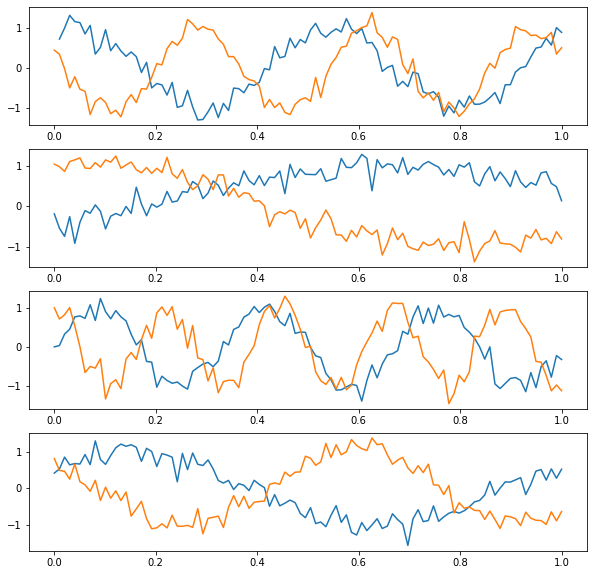

In [253]:
plot_data(Train_x, Train_y)

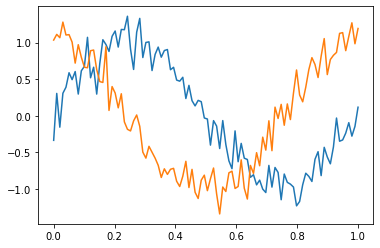

In [142]:
plt.plot(train_x, train_y)

# Kronecker MGP here

In [92]:
#MGP Model Class
class MultitaskGPModel(gpytorch.models.ExactGP ):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=2
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(), num_tasks=2, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)



In [254]:
train_x = Train_x
train_y = Train_y

In [255]:
train_x = train_x.unsqueeze(-1)

In [256]:
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
model = MultitaskGPModel(train_x, train_y, likelihood)

In [257]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.01)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

n_iter = 50
for i in range(n_iter):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y).mean() #.mean()
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, n_iter, loss.item()))
    optimizer.step()

RuntimeError: NaNs encounterd when trying to perform matrix-vector multiplication

In [241]:
# Set into eval mode
model.eval()
likelihood.eval()

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51).unsqueeze(0).repeat(4,1).unsqueeze(-1)
    predictions = likelihood(model(test_x))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()

# This contains predictions for both tasks, flattened out
# The first half of the predictions is for the first task
# The second half is for the second task


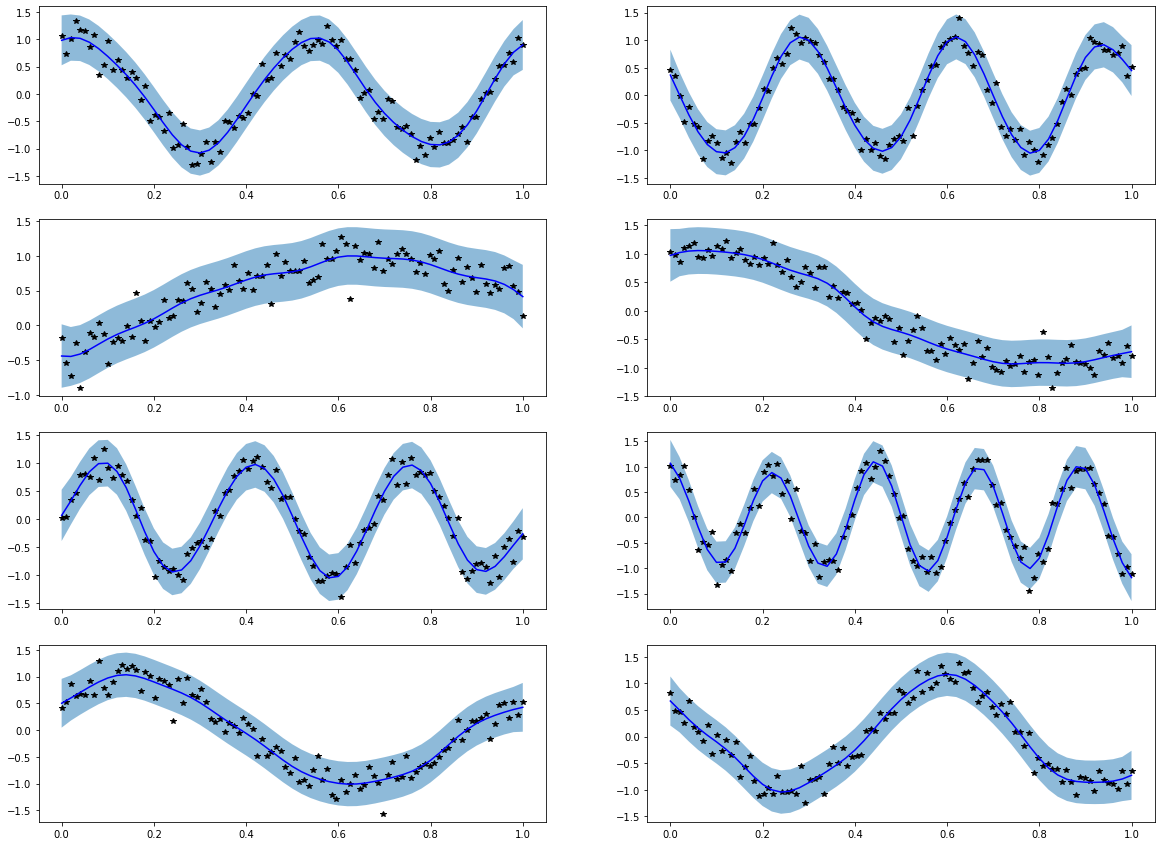

In [242]:
# Initialize plots
f, ax = plt.subplots(4, 2, figsize=(20, 15))

n_samples = test_x.shape[0]
n_tasks = train_y.shape[-1]
for i in np.arange(n_samples):
    for j in np.arange(n_tasks):
        # Plot training data as black stars
        ax[i,j].plot(train_x[i].detach().numpy(), train_y[i,:,j].detach().numpy(), 'k*')
        
        # Predictive mean as blue line
        ax[i,j].plot(test_x[i].numpy(), mean[i,:,j].numpy(), 'b')
        # Shade in confidence
        ax[i,j].fill_between(test_x[i].numpy().squeeze(), lower[i,:,j].numpy(), upper[i,:,j].numpy(), alpha=0.5)
        #ax[i,j].set_ylim([-3, 3])
        #ax[i,j].legend(['Observed Data', 'Mean', 'Confidence'])
        #ax[i,j].set_title('Observed Values (Likelihood)')


(51,)

In [ ]:
# Predictive mean as blue line
y1_ax.plot(test_x.numpy(), mean[:, 0].numpy(), 'b')
# Shade in confidence
y1_ax.fill_between(test_x.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
y1_ax.set_ylim([-3, 3])
y1_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y1_ax.set_title('Observed Values (Likelihood)')

# Plot training data as black stars
y2_ax.plot(train_x.detach().numpy(), train_y[:, 1].detach().numpy(), 'k*')
# Predictive mean as blue line
y2_ax.plot(test_x.numpy(), mean[:, 1].numpy(), 'b')
# Shade in confidence
y2_ax.fill_between(test_x.numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.5)
y2_ax.set_ylim([-3, 3])
y2_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y2_ax.set_title('Observed Values (Likelihood)')